In [1]:
import pandas as pd
import os
from pathlib import Path

# Дополнительный проект
В папке subsid (`shared/homeworks/python_ds_miniprojects/5_subsid`) находятся файлы (`tm_sales_1`, `tm_sales_2`, ...) с продажами продуктов через телемаркетинг. Каждый файл содержит, как минимум, 4 колонки (поля): `FILIAL_ID`, `SUBS_ID`, `PROD_ID`, `ACT_DTTM`.

Суть задачи в том, чтобы проверить подключения продуктов определенным пользователям, соединив файлы о продажах с логами по подключениям в системе.

**Особенности данных:**

- сотрудники телемаркетинга не всегда указывают полный id, если `'id'` нет в начале `SUBS_ID`, то нужно его добавить
- поля в файлах могут быть расположены абсолютно случайным образом, но названия полей статичны
- продажа не засчитывается, если отключение (`END_DTTM`) произошло меньше чем через 5 минут после подключения (`START_DTTM`)
- если в файле с продажами встречается строка без указанного `SUBS_ID`, она пропускается

Сохраните результат в датафрэйм с разделителем `;`, содержащий корректные подключения.

*Note:* обратите внимание на то, как pandas переводит дату из строки, возможно вам понадобится параметр `format`

Пример содержания итогового файла (колонка `difference` это разница между `START_DTTM` и `END_DTTM`):
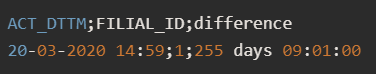

In [2]:
path = Path('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-elantsev/shared/homeworks/python_ds_miniprojects/5_subsid/subsid/')

for root, folder, files in os.walk(path):
    csvs = files[1:]

paths = [path / file for file in csvs]

In [3]:
# Готовим стартовый датафрейм
# Открываем датафрейм с таймлогом
prod_activations_logs = pd.read_csv(path / 'prod_activations_logs.csv', sep=';')

# Открываем каждый отчет
df = pd.read_csv(path / paths[0], sep=';')
df = df[['ACT_DTTM', 'FILIAL_ID', 'PROD_ID','SUBS_ID']]


df1 = pd.read_csv(path / paths[1], sep=';')
df1 = df1[['ACT_DTTM', 'FILIAL_ID', 'PROD_ID','SUBS_ID']]


df2 = pd.read_csv(path / paths[2], sep=';')
df2 = df2[['ACT_DTTM', 'FILIAL_ID', 'PROD_ID','SUBS_ID']]

# Объединяем в кучу
tm_sales = pd.concat([df, df1, df2])
# Удаляем строки с пропусками
tm_sales.dropna(inplace=True)
# Исправляем колоку SUBS_ID
tm_sales.SUBS_ID = tm_sales.apply({'SUBS_ID': lambda x: x if x.startswith('id') else 'id'+x})

In [4]:
tm_sales

,ACT_DTTM,FILIAL_ID,PROD_ID,SUBS_ID
0,20-03-2020 14:59,1,1954,id4651830
1,19-03-2020 13:00,5,6431,id7646509
2,22-03-2020 17:25,4,3313,id7412683
0,17-03-2020 10:17,3,1743,id5416547
2,05-03-2020 11:42,7,9879,id8362218
3,16-03-2020 16:28,2,3210,id2185490
0,18-03-2020 15:44,3,1499,id5764122
1,15-03-2020 14:21,6,3020,id7642700
2,17-03-2020 11:48,2,5677,id1374509


In [5]:
subsid_log = tm_sales.merge(prod_activations_logs, how='inner', on=['PROD_ID', 'SUBS_ID'])

In [6]:
subsid_log

,ACT_DTTM,FILIAL_ID,PROD_ID,SUBS_ID,START_DTTM,END_DTTM
0,20-03-2020 14:59,1,1954,id4651830,20-03-2020 14:59,01-12-2020 00:00
1,19-03-2020 13:00,5,6431,id7646509,19-03-2020 13:00,19-03-2020 13:03
2,17-03-2020 10:17,3,1743,id5416547,17-03-2020 10:17,25-03-2020 11:00
3,16-03-2020 16:28,2,3210,id2185490,16-03-2020 16:28,01-12-2020 00:00
4,15-03-2020 14:21,6,3020,id7642700,15-03-2020 14:21,15-03-2020 23:42


In [7]:
subsid_log[['ACT_DTTM', 'START_DTTM', 'END_DTTM']] = (subsid_log[['ACT_DTTM', 'START_DTTM', 'END_DTTM']]
                                                      .apply(pd.to_datetime, dayfirst=True)
                                                     )

In [8]:
subsid_log.dtypes

ACT_DTTM      datetime64[ns]
FILIAL_ID              int64
PROD_ID                int64
SUBS_ID               object
START_DTTM    datetime64[ns]
END_DTTM      datetime64[ns]
dtype: object

In [9]:
subsid_log['difference'] = subsid_log.END_DTTM - subsid_log.START_DTTM

In [10]:
subsid_log.query("difference >= '5m'")

,ACT_DTTM,FILIAL_ID,PROD_ID,SUBS_ID,START_DTTM,END_DTTM,difference
0,2020-03-20 14:59:00,1,1954,id4651830,2020-03-20 14:59:00,2020-12-01 00:00:00,255 days 09:01:00
2,2020-03-17 10:17:00,3,1743,id5416547,2020-03-17 10:17:00,2020-03-25 11:00:00,8 days 00:43:00
3,2020-03-16 16:28:00,2,3210,id2185490,2020-03-16 16:28:00,2020-12-01 00:00:00,259 days 07:32:00
4,2020-03-15 14:21:00,6,3020,id7642700,2020-03-15 14:21:00,2020-03-15 23:42:00,0 days 09:21:00


## 💀 Сложное задание! 💀

Для проверки результатов введите `SUBS_ID` из полученного датасета в порядке возрастания, через запятую с пробелом.

In [11]:
res = subsid_log.query("difference >= '5m'").sort_values('SUBS_ID').SUBS_ID.to_list()

In [12]:
[print(i, end=', ') for i in res]

id2185490, id4651830, id5416547, id7642700, 

[None, None, None, None]

In [13]:
print(', '.join(res))

id2185490, id4651830, id5416547, id7642700
